<a href="https://colab.research.google.com/github/git-hatano/Pytorch-DLPrograming/blob/main/ch09_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 9章 CIFAR10を使った画像認識

In [ ]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [ ]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [ ]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [ ]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

### GPUチェック

In [ ]:
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 9.3 CNNの処理概要

In [ ]:
data_root = './data'

# サンプルの手書き数字データを取得
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root,  train = True,  
    download = True, transform = transform)

image, label = train_set[0]
image = image.view(1,1,28,28)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
# 対角線上にのみ重みを持つ特殊な畳み込み関数を作る
conv1 = nn.Conv2d(1, 1, 3)

# biasを0に
nn.init.constant_(conv1.bias, 0.0)

# weightを特殊な値に
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1,1,3,3)
conv1.weight.data = w1

In [ ]:
# 手書き数字に3回畳み込み処理を行う
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

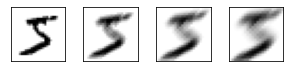

In [ ]:
# 結果の画面表示

plt.figure(figsize=(5, 1))
for i in range(4):
    size = 28 - i*2
    ax = plt.subplot(1, 4, i+1)
    img = images[i].data.numpy()
    plt.imshow(img.reshape(size, size),cmap='gray_r')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 9.4 PyTorchでのCNN実装

### nn.Conv2d とnn.MaxPool2d

In [ ]:
# CNN前半部分 レイヤー関数の定義

conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))

In [ ]:
# conv1の確認
print(conv1)

# conv1の内部変数のshape確認
print(conv1.weight.shape)
print(conv1.bias.shape)

# conv2の内部変数のshape確認
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [ ]:
# conv1のweight[0]とは、出力チャネル0用の重み
w = conv1.weight[0]

# waeight[0]のshapeと値の確認
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[-0.03765 -0.11816 -0.18979]
  [-0.17322  0.00827 -0.17888]
  [ 0.01825  0.14184  0.1857 ]]

 [[ 0.03814  0.03499 -0.00569]
  [-0.19019  0.05723  0.0919 ]
  [-0.04953 -0.0352   0.12504]]

 [[-0.1438   0.16937  0.14664]
  [-0.14632  0.10459  0.05468]
  [-0.03553  0.00314  0.11304]]]


In [ ]:
# ダミーで入力と同じサイズのTensorを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [ ]:
# CNNの前半部分をシミュレーションする

x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [ ]:
# それぞれのshapeの確認

print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


### nn.Sequential

In [ ]:
# 関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [ ]:
# 動作テスト
outputs = features(inputs)

# 結果確認
print(outputs.shape)

torch.Size([100, 32, 14, 14])


### nn.Flatten

In [ ]:
# 関数定義
flatten = nn.Flatten()

# 動作テスト
outputs2 = flatten(outputs)

# 結果確認
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


## 9.4 共通関数の定義

### eval_loss 損失計算用

In [ ]:
# 損失計算用
def eval_loss(loader, device, net, criterion):
  
    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break

    # デバイスの割り当て
    inputs = images.to(device)
    labels = labels.to(device)

    # 予測計算
    outputs = net(inputs)

    #  損失計算
    loss = criterion(outputs, labels)

    return loss

### fit 学習用

In [ ]:
# 学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

    # tqdmライブラリのインポート
    from tqdm.notebook import tqdm

    base_epochs = len(history)
  
    for epoch in range(base_epochs, num_epochs+base_epochs):
        train_loss = 0
        train_acc = 0
        val_loss = 0
        val_acc = 0

        #訓練フェーズ
        net.train()
        count = 0

        for inputs, labels in tqdm(train_loader):
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 勾配の初期化
            optimizer.zero_grad()

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            train_loss += loss.item()

            # 勾配計算
            loss.backward()

            # パラメータ修正
            optimizer.step()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            train_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_train_loss = train_loss / count
            avg_train_acc = train_acc / count

        #予測フェーズ
        net.eval()
        count = 0

        for inputs, labels in test_loader:
            count += len(labels)
            inputs = inputs.to(device)
            labels = labels.to(device)

            # 予測計算
            outputs = net(inputs)

            # 損失計算
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # 予測値算出
            predicted = torch.max(outputs, 1)[1]

            # 正解件数算出
            val_acc += (predicted == labels).sum()

            # 損失と精度の計算
            avg_val_loss = val_loss / count
            avg_val_acc = val_acc / count
    
        print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
        item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
        history = np.vstack((history, item))
    return history

### eval_history 学習ログ解析用

In [ ]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

### show_images_labels イメージとラベルの表示

In [ ]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()


### torch_seed 乱数固定用

In [ ]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True


## 9.6 データ準備

In [ ]:
# Transformsの定義

# transformer1 1階テンソル化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [ ]:
# データ取得用関数 Datasets

data_root = './data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### データセットの確認

In [ ]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [ ]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 


In [ ]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)


torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


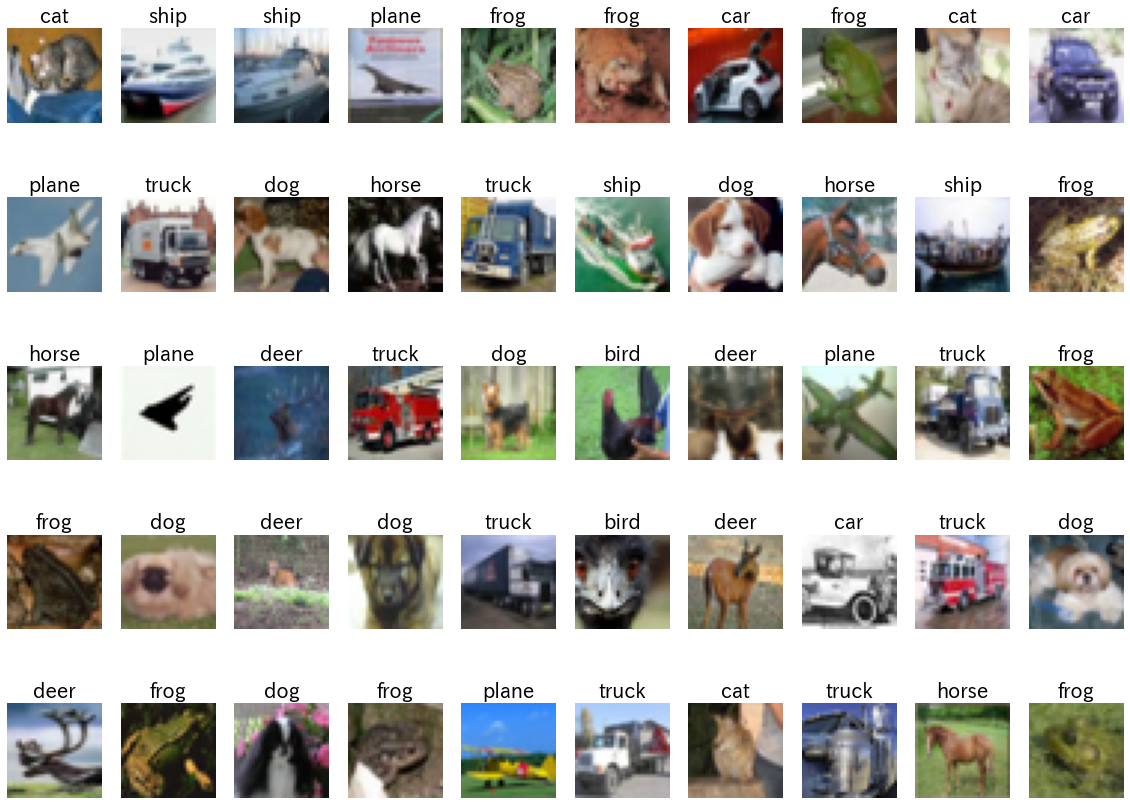

In [ ]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

## 9.7 モデル定義(全結合版)

### 学習用パラメータ設定

In [ ]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels1.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [ ]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

### モデルインスタンス生成とGPUの割り当て

In [ ]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [ ]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

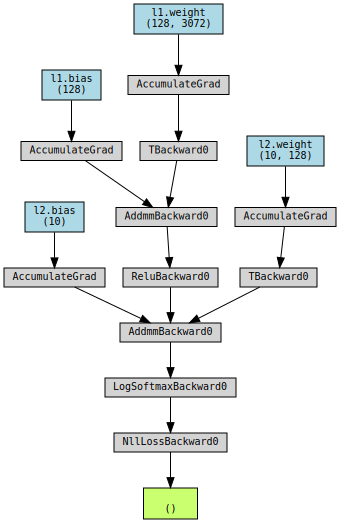

In [ ]:
# 損失計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.8 結果(全結合版)

### 学習

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32202 val_loss: 0.01794, val_acc: 0.37690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39564 val_loss: 0.01684, val_acc: 0.41750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42438 val_loss: 0.01622, val_acc: 0.43790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44244 val_loss: 0.01583, val_acc: 0.45050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45532 val_loss: 0.01553, val_acc: 0.46160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46828 val_loss: 0.01530, val_acc: 0.46830


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47710 val_loss: 0.01512, val_acc: 0.47370


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48630 val_loss: 0.01493, val_acc: 0.47820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49582 val_loss: 0.01480, val_acc: 0.48730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50448 val_loss: 0.01463, val_acc: 0.49030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51178 val_loss: 0.01450, val_acc: 0.49610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.51942 val_loss: 0.01437, val_acc: 0.50320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52648 val_loss: 0.01425, val_acc: 0.50610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53516 val_loss: 0.01422, val_acc: 0.50550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01340 acc: 0.53926 val_loss: 0.01407, val_acc: 0.51350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54590 val_loss: 0.01402, val_acc: 0.51100


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55192 val_loss: 0.01390, val_acc: 0.51470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55692 val_loss: 0.01388, val_acc: 0.51460


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01278 acc: 0.56150 val_loss: 0.01379, val_acc: 0.52150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56654 val_loss: 0.01381, val_acc: 0.51710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57144 val_loss: 0.01372, val_acc: 0.51860


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01237 acc: 0.57702 val_loss: 0.01368, val_acc: 0.52510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58062 val_loss: 0.01363, val_acc: 0.52500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58446 val_loss: 0.01355, val_acc: 0.52440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59158 val_loss: 0.01352, val_acc: 0.52700


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01189 acc: 0.59336 val_loss: 0.01351, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01177 acc: 0.59864 val_loss: 0.01350, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01166 acc: 0.60222 val_loss: 0.01343, val_acc: 0.52950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60546 val_loss: 0.01342, val_acc: 0.52680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60932 val_loss: 0.01346, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61520 val_loss: 0.01341, val_acc: 0.52920


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61778 val_loss: 0.01338, val_acc: 0.52840


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62132 val_loss: 0.01338, val_acc: 0.53030


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62500 val_loss: 0.01342, val_acc: 0.52660


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01095 acc: 0.62900 val_loss: 0.01340, val_acc: 0.52650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63228 val_loss: 0.01334, val_acc: 0.53140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01076 acc: 0.63594 val_loss: 0.01339, val_acc: 0.52850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01067 acc: 0.64010 val_loss: 0.01336, val_acc: 0.53060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64222 val_loss: 0.01341, val_acc: 0.53220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01050 acc: 0.64574 val_loss: 0.01348, val_acc: 0.52480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01040 acc: 0.64930 val_loss: 0.01341, val_acc: 0.52740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65106 val_loss: 0.01347, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65266 val_loss: 0.01345, val_acc: 0.52510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65624 val_loss: 0.01346, val_acc: 0.52870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.66040 val_loss: 0.01345, val_acc: 0.52780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01000 acc: 0.66152 val_loss: 0.01344, val_acc: 0.53040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66366 val_loss: 0.01348, val_acc: 0.52710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00984 acc: 0.66836 val_loss: 0.01350, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67088 val_loss: 0.01362, val_acc: 0.52040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00970 acc: 0.67264 val_loss: 0.01352, val_acc: 0.53070


### 評価

初期状態: 損失: 0.01794 精度: 0.37690
最終状態: 損失: 0.01352 精度: 0.53070


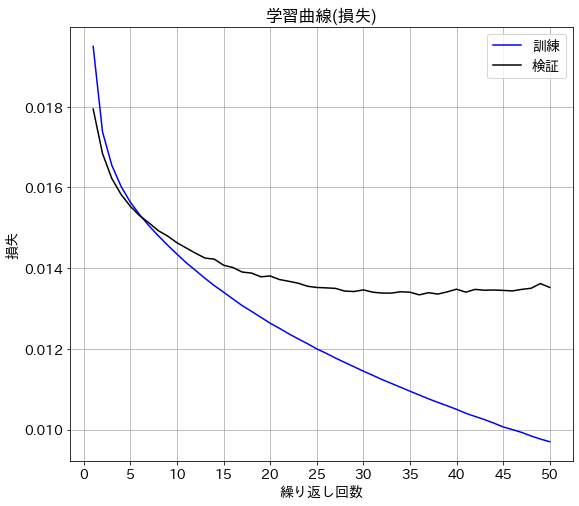

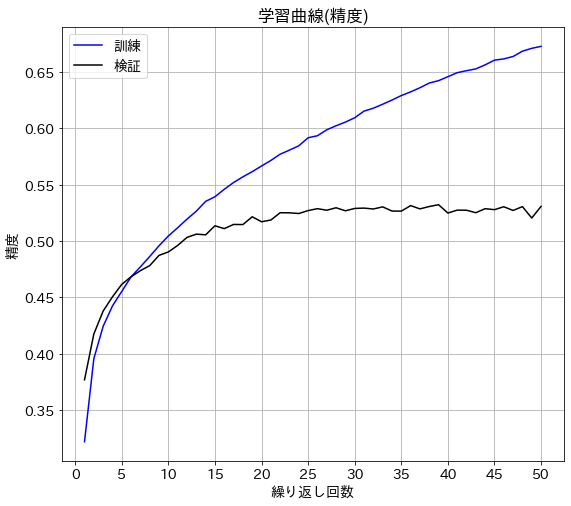

In [ ]:
# 評価

evaluate_history(history)

## 9.9 モデル定義(CNN版)

In [ ]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

### モデルインスタンスの生成

In [ ]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [ ]:
# モデルの概要表示

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [ ]:
# モデルのサマリー表示

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Conv2d: 1-2                            [100, 32, 30, 30]         896
├─ReLU: 1-3                              [100, 32, 30, 30]         --
├─Conv2d: 1-4                            [100, 32, 28, 28]         9,248
├─ReLU: 1-5                              [100, 32, 28, 28]         --
├─MaxPool2d: 1-6                         [100, 32, 14, 14]         --
├─Flatten: 1-7                           [100, 6272]               --
├─Sequential: 1-8                        [100, 10]                 804,234
├─Linear: 1-9                            [100, 128]                802,944
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 10]                 1,290
Total params: 814,378
Trainable params: 814,378
Non-trainable pa

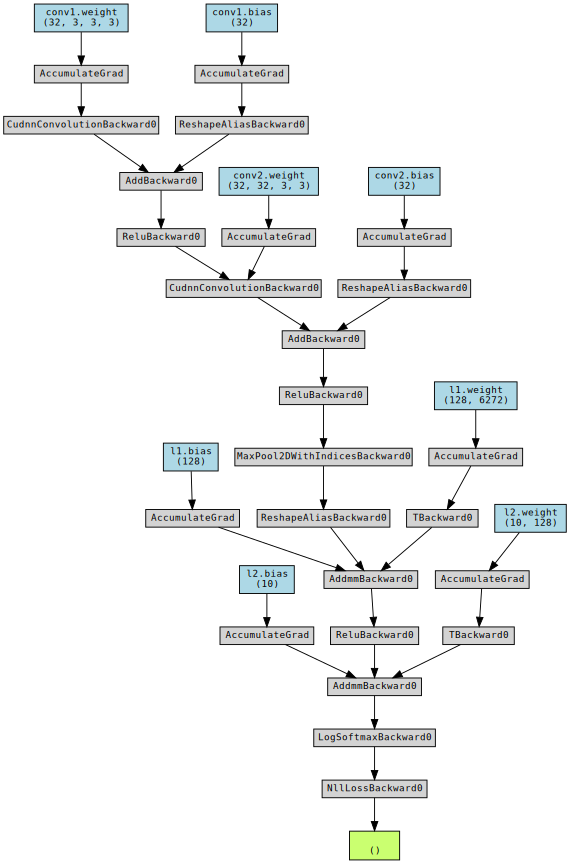

In [ ]:
# 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

## 9.10 結果(CNN版)

### 学習

In [ ]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02082 acc: 0.26088 val_loss: 0.01866, val_acc: 0.34740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37308 val_loss: 0.01677, val_acc: 0.40930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43044 val_loss: 0.01530, val_acc: 0.46080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47332 val_loss: 0.01448, val_acc: 0.48970


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49932 val_loss: 0.01369, val_acc: 0.51230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01350 acc: 0.52114 val_loss: 0.01333, val_acc: 0.52580


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53714 val_loss: 0.01293, val_acc: 0.54000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01252 acc: 0.55358 val_loss: 0.01254, val_acc: 0.55120


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57398 val_loss: 0.01234, val_acc: 0.56260


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59184 val_loss: 0.01182, val_acc: 0.58130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01116 acc: 0.60874 val_loss: 0.01162, val_acc: 0.59020


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62348 val_loss: 0.01170, val_acc: 0.58400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63646 val_loss: 0.01112, val_acc: 0.60590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00997 acc: 0.64954 val_loss: 0.01090, val_acc: 0.61300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00959 acc: 0.66510 val_loss: 0.01109, val_acc: 0.60350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00922 acc: 0.67704 val_loss: 0.01055, val_acc: 0.63250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00882 acc: 0.69122 val_loss: 0.01064, val_acc: 0.62500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00847 acc: 0.70370 val_loss: 0.01012, val_acc: 0.64670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00809 acc: 0.71920 val_loss: 0.01022, val_acc: 0.64280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00774 acc: 0.73078 val_loss: 0.01048, val_acc: 0.63510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00739 acc: 0.74220 val_loss: 0.01000, val_acc: 0.65500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00703 acc: 0.75684 val_loss: 0.01016, val_acc: 0.65210


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76700 val_loss: 0.00993, val_acc: 0.65950


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00637 acc: 0.77990 val_loss: 0.00999, val_acc: 0.66060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79188 val_loss: 0.00999, val_acc: 0.66820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00569 acc: 0.80608 val_loss: 0.01051, val_acc: 0.64670


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00540 acc: 0.81360 val_loss: 0.01058, val_acc: 0.65930


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00509 acc: 0.82648 val_loss: 0.01137, val_acc: 0.63910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00474 acc: 0.83974 val_loss: 0.01048, val_acc: 0.66540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00442 acc: 0.85094 val_loss: 0.01110, val_acc: 0.65630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00409 acc: 0.86296 val_loss: 0.01100, val_acc: 0.66870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00381 acc: 0.87214 val_loss: 0.01140, val_acc: 0.65850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00352 acc: 0.88358 val_loss: 0.01122, val_acc: 0.66510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00324 acc: 0.89232 val_loss: 0.01209, val_acc: 0.65570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00294 acc: 0.90472 val_loss: 0.01257, val_acc: 0.65600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00270 acc: 0.91212 val_loss: 0.01274, val_acc: 0.65220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00240 acc: 0.92540 val_loss: 0.01270, val_acc: 0.66150


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00216 acc: 0.93350 val_loss: 0.01321, val_acc: 0.66550


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00192 acc: 0.94208 val_loss: 0.01371, val_acc: 0.66470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00173 acc: 0.95202 val_loss: 0.01470, val_acc: 0.65750


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00144 acc: 0.96146 val_loss: 0.01494, val_acc: 0.65850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00125 acc: 0.96768 val_loss: 0.01518, val_acc: 0.65800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00109 acc: 0.97378 val_loss: 0.01713, val_acc: 0.63600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00090 acc: 0.98114 val_loss: 0.01602, val_acc: 0.66240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00086 acc: 0.98198 val_loss: 0.01637, val_acc: 0.66050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00087 acc: 0.98410 val_loss: 0.01678, val_acc: 0.66000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00050 acc: 0.99362 val_loss: 0.01711, val_acc: 0.66520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00036 acc: 0.99644 val_loss: 0.01769, val_acc: 0.66220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00029 acc: 0.99762 val_loss: 0.01858, val_acc: 0.66240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00024 acc: 0.99836 val_loss: 0.01873, val_acc: 0.66340


### 評価

初期状態: 損失: 0.01866 精度: 0.34740
最終状態: 損失: 0.01873 精度: 0.66340


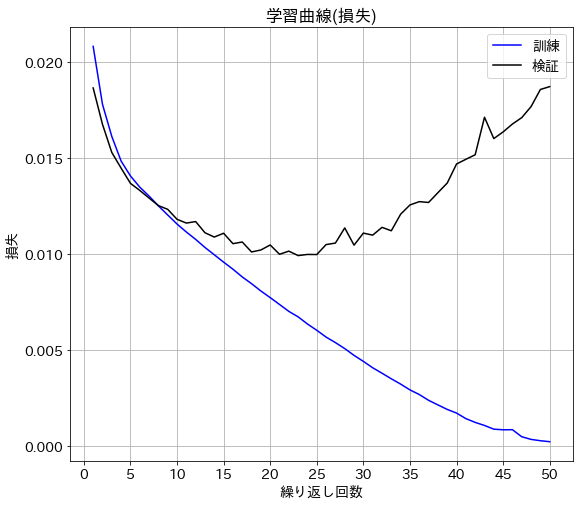

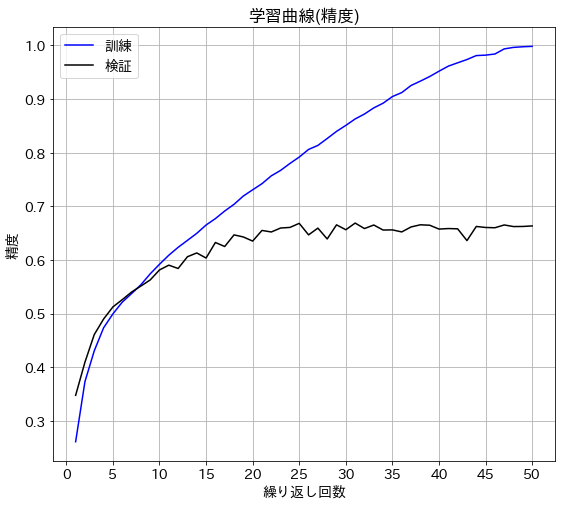

In [ ]:
# 評価

evaluate_history(history2)

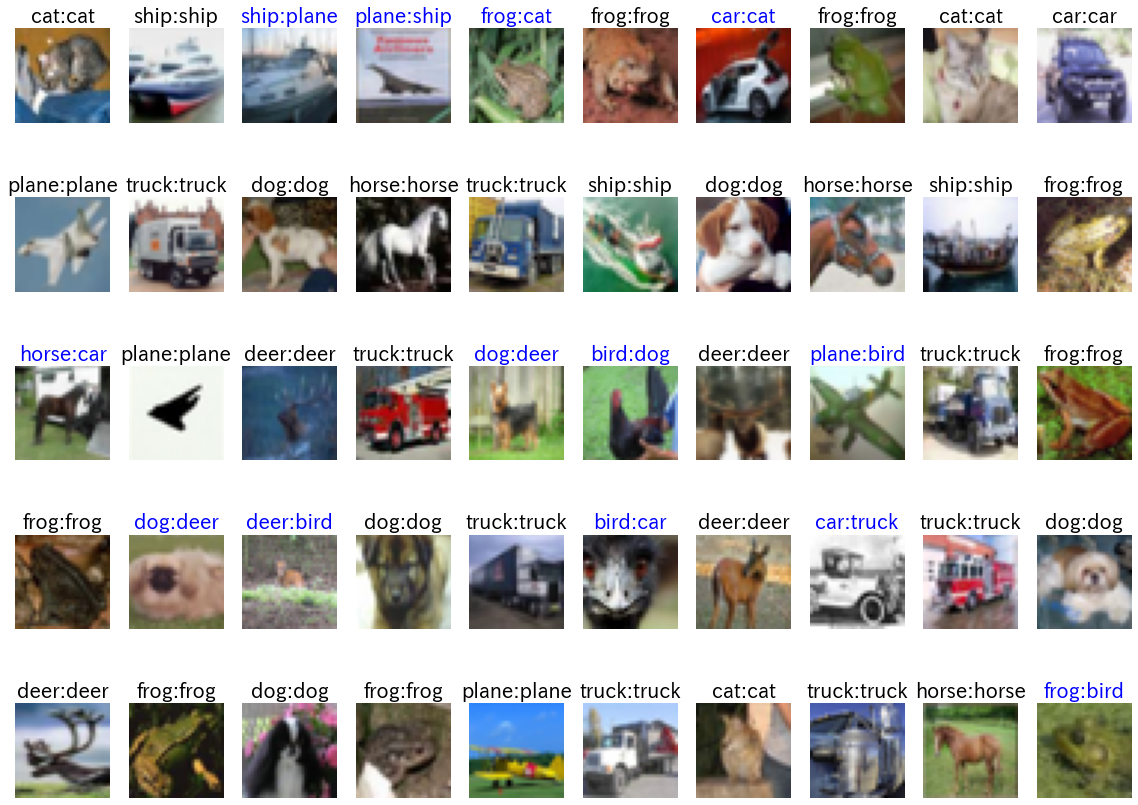

In [ ]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)